In [45]:
import pandas as pd
import configparser
import requests
import matplotlib.pyplot as plt

In [ ]:
# Load credentials from config file
config = configparser.ConfigParser()
config.read('pyalgo.cfg')

consumer_id = config['ssi']['ConsumerID']
consumer_secret = config['ssi']['ConsumerSecret']
private_key = config['ssi']['PrivateKey']

In [58]:
# Step 1: Request access token
def get_access_token(consumer_id, consumer_secret, private_key):
    url = "https://fc-data.ssi.com.vn/api/v2/Market/AccessToken"
    headers = {"Content-Type": "application/json"}
    data = {
        "consumerID": consumer_id,
        "consumerSecret": consumer_secret,
        "privateKey": private_key
    }
    res = requests.post(url, json=data, headers=headers)
    res.raise_for_status()
    response = res.json()

    # Extract access token from response
    if "data" in response and "accessToken" in response["data"]:
        return response["data"]["accessToken"]
    else:
        raise ValueError("Access token not found in response:", response)

# Step 2: Get stock price using access token
def get_stock_price(symbol, token):
    url = "https://fc-data.ssi.com.vn/api/v2/Market/DailyStockPrice"
    headers = {
        "Authorization": f"Bearer {token}",
        "Accept": "application/json"
    }
    params = {
        "Symbol": symbol,
        "FromDate": "01/04/2025",
        "ToDate": "24/04/2025",
        "Market": "HOSE",
        "PageIndex": "1",
        "PageSize": "50"
    }
    res = requests.get(url, headers=headers, params=params)
    res.raise_for_status()
    return res.json()

In [59]:
# Run the process
token = get_access_token(consumer_id, consumer_secret, private_key)

In [60]:
data = get_stock_price("VCB", token)

In [61]:
df = pd.DataFrame(data['data'])

In [62]:
test = df[df['Symbol'] == 'VCB']

In [43]:
test['ClosePrice']

225      64500
4171     64800
8117     60300
12063    60000
16009    55800
19956    52500
23903    56100
27850    59800
31797    59300
35744    60000
39691    59300
43638    58100
47585    58100
51532    58200
55538    58500
59546    58000
63554    58200
Name: ClosePrice, dtype: object

/tmp/ipykernel_1516/2909226227.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['TradingDate'] = pd.to_datetime(test['TradingDate'], dayfirst=True)
/tmp/ipykernel_1516/2909226227.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['ClosePrice'] = pd.to_numeric(test['ClosePrice'], errors='coerce')


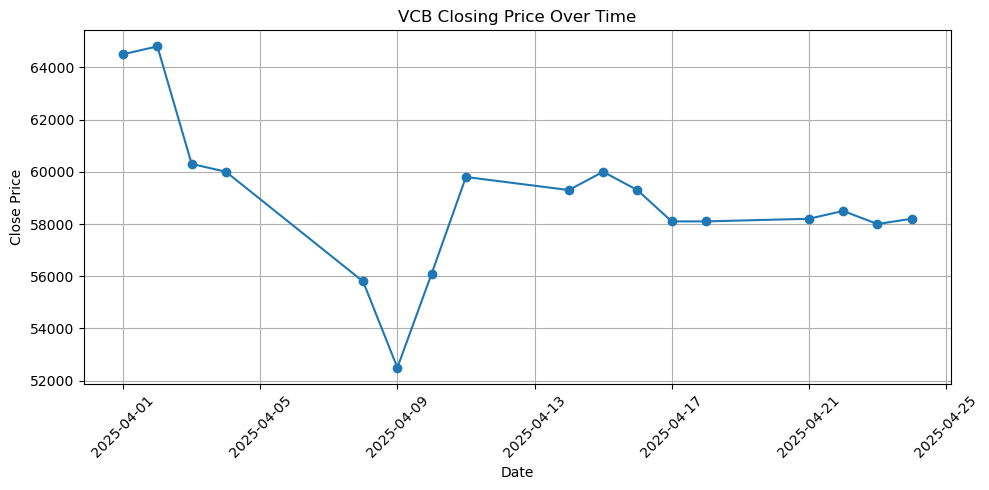

In [63]:
# Ensure correct types
test['TradingDate'] = pd.to_datetime(test['TradingDate'], dayfirst=True)
test['ClosePrice'] = pd.to_numeric(test['ClosePrice'], errors='coerce')

# Sort by date
test = test.sort_values('TradingDate')

# Plot
plt.figure(figsize=(10, 5))
plt.plot(test['TradingDate'], test['ClosePrice'], marker='o')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.title('VCB Closing Price Over Time')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [57]:
df

""
